## Does weather play a factor in when deliveries occur?

In [1]:
#Import Libraries
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,LogisticRegressionCV,LassoCV,ElasticNetCV,RidgeCV,RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RepeatedKFold, StratifiedKFold, train_test_split, cross_val_score,cross_val_predict,RepeatedStratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
#load dataset into a dataframe and confirm values
df_raw = pd.read_csv('DataSets\\Savage_Daily_Ticket_Count_Weather_Export.csv')
df_raw.head(12)

,delivery_count_sum,is_above_average_delivery_day,log_ratio_to_average,delivery_date,delivery_weekday_name,is_midweek,DailyPrecipitation,DailySnowDepth,SnowOnGround,DailySnowfall,...,PriorDayPrecipitationAmt,Prior2DayPrecipitationAmt,PriorDayPrecipitationDiff,Prior2DayPrecipitationDiff,PriorDaySnowfallAmt,PriorDaySnowfallDiff,Precip_12AM-6AM,Precip_6AM-10AM,Precip_6AM-12PM,Precip_10AM-2PM
0,2,False,0.000000,2021-01-07,Thu,True,0.00,8,True,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,No Precip,No Precip,No Precip,No Precip
1,2,False,0.000000,2020-01-10,Fri,False,0.00,3,True,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,No Precip,No Precip,No Precip,No Precip
2,1,False,0.000000,2011-01-13,Thu,True,0.08,10,True,1.9,...,0.00,0.10,0.08,-0.02,0.0,1.9,No Precip,No Precip,Light Precip,Precip
3,1,False,0.000000,2011-01-24,Mon,False,0.01,12,True,0.1,...,0.00,0.00,0.01,0.01,0.0,0.1,No Precip,No Precip,No Precip,Light Precip
4,2,False,0.000000,2018-01-31,Wed,True,0.13,5,True,2.1,...,0.00,0.00,0.13,0.13,0.0,2.1,Precip,No Precip,No Precip,No Precip
5,1,False,0.000000,2013-02-06,Wed,True,0.04,5,True,0.7,...,0.05,0.06,-0.01,-0.02,1.2,-0.5,No Precip,No Precip,Light Precip,Light Precip
6,2,False,0.000000,2017-02-09,Thu,True,0.00,0,False,0.0,...,0.00,0.01,0.00,-0.01,0.0,0.0,No Precip,No Precip,No Precip,No Precip
7,1,False,0.000000,2020-02-13,Thu,True,0.00,9,True,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,No Precip,No Precip,No Precip,No Precip
8,12,False,0.000000,2016-02-25,Thu,True,0.00,0,False,0.0,...,0.00,0.04,0.00,-0.04,0.0,0.0,No Precip,No Precip,No Precip,No Precip
9,5,False,-0.903090,2013-02-26,Tue,True,0.00,6,True,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,No Precip,No Precip,No Precip,No Precip


Response varaibles are:  
delivery_count_sum -> total deliveries for the date

log_ratio_to_average -> ratio of today's deliveries to the average on that day for the last 11 years (log transformed to normallize)

is_above_average_delivery_day -> to try logistic regression:  True if greater than the average

In [3]:
#establish the working set
df = df_raw.copy()

#don't need the delivery date field for analysis nor the day name
df = df.drop(['delivery_date','delivery_weekday_name'],axis=1)

#set values to string for analysis
df['SnowOnGround'] = df['SnowOnGround'].astype(str)
df['is_midweek'] = df['is_midweek'].astype(str)


In [4]:
#Correlations have been checked in dataset building, but will put a matrix up for completeness
corr = df_raw.corr()
corr.style.background_gradient(cmap='coolwarm')

,delivery_count_sum,is_above_average_delivery_day,log_ratio_to_average,is_midweek,DailyPrecipitation,DailySnowDepth,SnowOnGround,DailySnowfall,PriorDayAverageDryBulbTemperatureDiff,PriorDayMaximumTemperatureDiff,PriorDayMinimumTemperatureDiff,PriorDayPrecipitationAmt,Prior2DayPrecipitationAmt,PriorDayPrecipitationDiff,Prior2DayPrecipitationDiff,PriorDaySnowfallAmt,PriorDaySnowfallDiff
delivery_count_sum,1.000000,0.699812,0.684540,0.033508,0.013602,-0.180256,-0.209841,-0.092842,0.017620,0.013661,0.018282,0.015692,0.056086,-0.002015,-0.030033,-0.093728,-0.005833
is_above_average_delivery_day,0.699812,1.000000,0.715765,0.039456,-0.012871,-0.107103,-0.104156,-0.067173,0.002460,-0.003605,0.008667,-0.011272,0.006752,-0.000803,-0.013905,-0.056636,-0.012099
log_ratio_to_average,0.684540,0.715765,1.000000,0.010904,-0.026159,-0.140165,-0.137056,-0.085994,0.002544,-0.000205,0.007628,-0.036993,-0.002928,0.009038,-0.016482,-0.111550,0.012032
is_midweek,0.033508,0.039456,0.010904,1.000000,0.042467,0.033734,0.039789,0.010758,-0.031163,-0.045758,-0.002174,0.011202,0.008966,0.022340,0.023776,0.010489,0.000938
DailyPrecipitation,0.013602,-0.012871,-0.026159,0.042467,1.000000,-0.046065,-0.053277,0.129491,-0.108592,-0.148424,-0.016733,0.091786,0.003535,0.656371,0.706736,-0.023907,0.117129
DailySnowDepth,-0.180256,-0.107103,-0.140165,0.033734,-0.046065,1.000000,0.774955,0.160079,0.038992,0.028297,0.042128,-0.018210,-0.024930,-0.019643,-0.015033,0.375478,-0.140689
SnowOnGround,-0.209841,-0.104156,-0.137056,0.039789,-0.053277,0.774955,1.000000,0.238799,0.030078,0.020095,0.032926,-0.024059,-0.025300,-0.020447,-0.019887,0.374648,-0.079143
DailySnowfall,-0.092842,-0.067173,-0.085994,0.010758,0.129491,0.160079,0.238799,1.000000,-0.065219,-0.090589,-0.007391,-0.007207,-0.029462,0.099459,0.112684,0.088407,0.712090
PriorDayAverageDryBulbTemperatureDiff,0.017620,0.002460,0.002544,-0.031163,-0.108592,0.038992,0.030078,-0.065219,1.000000,0.897599,0.805128,-0.086567,-0.013921,-0.013242,-0.067169,-0.050120,-0.015179
PriorDayMaximumTemperatureDiff,0.013661,-0.003605,-0.000205,-0.045758,-0.148424,0.028297,0.020095,-0.090589,0.897599,1.000000,0.466969,-0.042807,0.026282,-0.075310,-0.123862,-0.022967,-0.053964


In [5]:
#function to handle multi-collinearity tests
def vif_calc(X):
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_info['Column'] = X.columns
    vif_info.sort_values('VIF', ascending=False)
    return(vif_info)

#function to pass back AIC for linear model

def aic_calc(X,Y):
    #add constant to predictor variables
    X = sm.add_constant(X)
    #fit regression model
    model = sm.OLS(Y, X).fit()
    return(model.aic)


In [6]:
#create data sets for analysis, keep x's separate in case I change individual tests first is regression against the delivery count
xc_full = df.drop(['delivery_count_sum','is_above_average_delivery_day','log_ratio_to_average'],axis=1)
xc_full = pd.get_dummies(xc_full,drop_first = True)                #make dummies for categorical values for analysis
yc = df['delivery_count_sum']

In [7]:
vif_calc(xc_full)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Column
0,inf,DailyPrecipitation
1,2.696621,DailySnowDepth
2,inf,DailySnowfall
3,265.041789,PriorDayAverageDryBulbTemperatureDiff
4,119.189091,PriorDayMaximumTemperatureDiff
5,65.842482,PriorDayMinimumTemperatureDiff
6,inf,PriorDayPrecipitationAmt
7,inf,Prior2DayPrecipitationAmt
8,inf,PriorDayPrecipitationDiff
9,inf,Prior2DayPrecipitationDiff


This data (as expected) has columns that have correlations.  In general the "Diff" fields are better distributed than the "Amt" so we will remove and run this again.  Also remove the "no precip" fields since they have high correlations.

In [8]:
temp_xc = xc_full.drop(['PriorDayPrecipitationAmt','Prior2DayPrecipitationAmt','PriorDaySnowfallAmt','Precip_12AM-6AM_No Precip','Precip_6AM-10AM_No Precip','Precip_6AM-12PM_No Precip','Precip_10AM-2PM_No Precip'],axis=1)
vif_calc(temp_xc)

,VIF,Column
0,3.688010,DailyPrecipitation
1,2.691790,DailySnowDepth
2,2.602310,DailySnowfall
3,264.790860,PriorDayAverageDryBulbTemperatureDiff
4,119.023235,PriorDayMaximumTemperatureDiff
5,65.791737,PriorDayMinimumTemperatureDiff
6,1.812148,PriorDayPrecipitationDiff
7,1.974165,Prior2DayPrecipitationDiff
8,2.454478,PriorDaySnowfallDiff
9,1.247900,is_midweek_True


All looking good except need to pick which Temperature Diff field to keep. Check for lowest AIC from keeping 1 of them.

In [9]:
aic_val =np.empty(4)
aic_val[0] = aic_calc(temp_xc,yc)
temp_x = temp_xc.drop(['PriorDayMaximumTemperatureDiff','PriorDayMinimumTemperatureDiff'],axis=1)
aic_val[1] = aic_calc(temp_x,yc)
temp_x = temp_xc.drop(['PriorDayMinimumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[2] = aic_calc(temp_x,yc)
temp_x = temp_xc.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[3] = aic_calc(temp_x,yc)
print(aic_val)

[27572.1525601  27568.91203952 27569.73295657 27568.29817082]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [10]:
xc_part = temp_xc.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
vif_calc(xc_part)

,VIF,Column
0,3.685394,DailyPrecipitation
1,2.690219,DailySnowDepth
2,2.594989,DailySnowfall
3,1.026933,PriorDayMinimumTemperatureDiff
4,1.811045,PriorDayPrecipitationDiff
5,1.963905,Prior2DayPrecipitationDiff
6,2.453428,PriorDaySnowfallDiff
7,1.246875,is_midweek_True
8,2.843407,SnowOnGround_True
9,1.395769,Precip_12AM-6AM_Precip


I now have a full datasets and a subset of data that has strong VIF stats.  I will run linear regression to get a baseline

In [11]:
#function to run baseline regression
def get_stats(x,y,log=False):
    if (log == True):
        results = sm.Logit(y,x).fit()
    else: results = sm.OLS(y,x).fit()
    print(results.summary())


In [12]:
#do linear regression on the full (for comparison) and then on the partial removing non-signficant p-values
#real models will have test/train data
get_stats(xc_full,yc)

get_stats(xc_part,yc) 
temp_xc = xc_part.drop(['PriorDaySnowfallDiff','Precip_10AM-2PM_Precip'],axis=1)
get_stats(temp_xc,yc) 

temp_xc = temp_xc.drop(['DailySnowDepth','DailySnowfall','Precip_6AM-10AM_Precip','Precip_6AM-12PM_Precip'],axis=1)
get_stats(temp_xc,yc) 

#capture the dataset used by linear regression
xc_sp = temp_xc


                                 OLS Regression Results                                
Dep. Variable:     delivery_count_sum   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.547
Method:                 Least Squares   F-statistic:                              143.3
Date:                Tue, 29 Mar 2022   Prob (F-statistic):                        0.00
Time:                        10:00:20   Log-Likelihood:                         -13779.
No. Observations:                2235   AIC:                                  2.760e+04
Df Residuals:                    2216   BIC:                                  2.770e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

set up models:  

Lasso & Elastic Net and "boosting" for of decisions trees for the full models (since they do various measures of feature selection) .

Ridge Regression and Random Forests for the partial datasets since they work better on models that don't have collinearity issues (which we've addressed).

In all cases, I will utilize cross validation on all the data to find the "Best" model, and then use a train/test set to get the  root mean squared error and R^2 values.

In [13]:
# set up functions to do cross validation on methods and to plot graphs
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation mean_squared_error', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()
    return()

def graph_result(X,Y_test,Y_pred):
    x_ax = range(len(X))
    plt.scatter(x_ax, Y_test, s=5, color="navy", label="original")
    plt.plot(x_ax, Y_pred, lw=0.8, color="gold", label="predicted")
    plt.legend()
    plt.show()
    return()

def run_linear(X,Y,graph=False):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)   
    
    #model = LinearRegression()
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X,Y)

    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    rmse_train = np.sqrt(mean_squared_error(y_train,pred_train))
    r2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
    
    return(rmse_test,r2_test)
    
def run_lasso(X,Y,graph=False,iter_nbr=1000,a_start = .01,a_stop = 1,a_step=.01):
    #X = predictors, Y = response, splits = cv splits
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    cv = RepeatedKFold(n_splits = 10,n_repeats=50, random_state=5440)   #set random_state to make results repeatable
    model = make_pipeline(StandardScaler(),LassoCV(alphas=np.arange(a_start,a_stop,a_step),cv=cv,tol = .005,max_iter=iter_nbr,n_jobs=-1))
    
    #fit the model on all the data to give us the optimal "alpha/lambda value"
    model.fit(X,Y)
      
    #Now, use the training and test sets to get the scoring
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    rmse_train = np.sqrt(mean_squared_error(y_train,pred_train))
    r2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
    
    return(rmse_test,r2_test)

def run_elastic_net(X,Y,graph=False,scaling_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9],iter_nbr=1000):
    #X = predictors, Y = response, scaling_list = the alpha values between 0 and 1, splits = cv splits
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    cv = RepeatedKFold(n_splits = 10,n_repeats=50, random_state=5440)   #set random_state to make results repeatable
    model = make_pipeline(StandardScaler(),ElasticNetCV(alphas=scaling_list,cv=cv,tol = .005,max_iter=iter_nbr,n_jobs=-1))
    
    #fit the model on all the data to give us the optimal "alpha/lambda value"
    model.fit(X,Y)
    
    #Now, use the training and test sets to get the scoring
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    rmse_train = np.sqrt(mean_squared_error(y_train,pred_train))
    r2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
        
    return(rmse_test,r2_test)

def run_ridge(X,Y,graph=False,a_start = 5,a_stop = 15,a_step=.1):
    #X = predictors, Y = response, other numbers for the range of values
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    cv = RepeatedKFold(n_splits = 10,n_repeats=50,  random_state=5440)   #set random_state to make results repeatable
    model = make_pipeline(StandardScaler(),RidgeCV(alphas=np.arange(a_start,a_stop,a_step),cv=cv))
    
    #fit the model on all the data to give us the optimal "alpha/lambda value"
    model.fit(X,Y)
     
    #Now, use the training and test sets to get the scoring
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    rmse_train = np.sqrt(mean_squared_error(y_train,pred_train))
    r2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
    
    return(rmse_test,r2_test)

# function for fitting trees of various depths using cross-validation
def run_cross_validation_on_regression_RF(X, Y, tree_depths, tree_nbr,cv=10, scoring='neg_root_mean_squared_error'):

    #set up "winners" list from cross reference
    best_RMSE = -1000000
    best_depth = 0
    best_tree_val = 0
    
    #for determining the best model, we will use all the data and run in through 10-fold cross validation
    for tree in tree_nbr:
        for depth in tree_depths:
            tree_model = make_pipeline(StandardScaler(),RandomForestRegressor(max_depth=depth, n_estimators=tree,random_state=5440))
            cv_scores = cross_val_score(tree_model, X, Y, cv=cv, scoring=scoring,n_jobs=-1)
            if (cv_scores.mean() > best_RMSE):                        #use > since it is negative
                best_RMSE = cv_scores.mean()
                best_depth = depth
                best_tree_val = tree 

    print(f'best_depth = {best_depth} | best_tree_val = {best_tree_val}')
    #now take the best and do a single run to fit on the training data and predict
        
    #split data for the final run
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    
    final_tree = RandomForestRegressor(max_depth=best_depth,n_estimators=best_tree_val,random_state=5440)
    final_tree.fit(x_train,y_train)

    #Now, use the training and test sets to get the scoring
    pred_train = final_tree.predict(x_train)
    pred_test = final_tree.predict(x_test)
    rmse_train = np.sqrt(mean_squared_error(y_train,pred_train))
    r2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    return(rmse_test,r2_test)

def run_cross_validation_on_regression_Boost(X, Y, tree_depths, tree_nbr,cv=10, scoring='neg_root_mean_squared_error'):

    #set up "winners" list from cross reference
    best_RMSE = -1000000
    best_depth = 0
    best_tree_val = 0
    
    #for determining the best model, we will use all the data and run in through 10-fold cross validation
    for tree in tree_nbr:
        for depth in tree_depths:
            tree_model = make_pipeline(StandardScaler(),GradientBoostingRegressor(max_depth=depth, n_estimators=tree,random_state=5440))
            cv_scores = cross_val_score(tree_model, X, Y, cv=cv, scoring=scoring,n_jobs=-1)
            if (cv_scores.mean() > best_RMSE):                        #use > since it is negative
                best_RMSE = cv_scores.mean()
                best_depth = depth
                best_tree_val = tree 

    print(f'best_depth = {best_depth} | best_tree_val = {best_tree_val}')
    #now take the best and do a single run to fit on the training data and predict
        
    #split data for the final run
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    
    final_tree = GradientBoostingRegressor(max_depth=best_depth,n_estimators=best_tree_val,random_state=5440)
    final_tree.fit(x_train,y_train)

    #Now, use the training and test sets to get the scoring
    pred_train = final_tree.predict(x_train)
    pred_test = final_tree.predict(x_test)
    rmse_train = np.sqrt(mean_squared_error(y_train,pred_train))
    r2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    return(rmse_test,r2_test)


In [14]:
# With the regression functions defined, run the regressions and capture the RMSE and R-squared
linear_rmse,linear_r2 = run_linear(xc_part,yc)
print(f'Linear Model on Data Subset Complete')
linear_sp_rmse,linear_sp_r2 = run_linear(xc_sp,yc)
print(f'Linear Model on Significant P Values Complete')
lasso_rmse,lasso_r2 = run_lasso(xc_full,yc,iter_nbr=5000)
print(f'Lasso Model on Full Dataset Complete')
lasso_part_rmse,lasso_part_r2 = run_lasso(xc_part,yc,iter_nbr=5000)
print(f'Lasso Model on Data Subset Complete')
enet_rmse,enet_r2 = run_elastic_net(xc_full,yc,scaling_list=[.01,.02,.03,.04,.05,.06,.07,.08,.09,.1],iter_nbr=5000)
print(f'Elastic Net Model on Full Dataset Complete')
enet_part_rmse,enet_part_r2 = run_elastic_net(xc_part,yc,scaling_list=[.01,.02,.03,.04,.05,.06,.07,.08,.09,.1],iter_nbr=5000)
print(f'Elastic Net Model on Data Subset Complete')
ridge_rmse,ridge_r2 = run_ridge(xc_part,yc,a_start = 14,a_stop = 30,a_step=.2)
print(f'Ridge Model on Data Subset Complete')
ridge_sp_rmse,ridge_sp_r2 = run_ridge(xc_sp,yc)
print(f'Ridge Model on Significant P Values Complete')

Linear Model on Data Subset Complete
Linear Model on Significant P Values Complete
Lasso Model on Full Dataset Complete
Lasso Model on Data Subset Complete
Elastic Net Model on Full Dataset Complete
Elastic Net Model on Data Subset Complete
Ridge Model on Data Subset Complete
Ridge Model on Significant P Values Complete


In [15]:
#decision tree classfiications
# fitting trees of depth 1 to 9 and of size 500,1500,2500
sm_tree_depths = range(1,10)
sm_tree_nbr = range(500,2500,1000)
rfr_rmse,rfr_r2 = run_cross_validation_on_regression_RF(xc_part,yc,sm_tree_depths,sm_tree_nbr)
print(f'Random Forest Model on Data Subset Complete')
rfr_sp_rmse,rfr_sp_r2 = run_cross_validation_on_regression_RF(xc_sp,yc,sm_tree_depths,sm_tree_nbr)
print(f'Random Forest Model on Significant P Values Complete')
boost_rmse,boost_r2 = run_cross_validation_on_regression_Boost(xc_full,yc,sm_tree_depths,sm_tree_nbr)
print(f'Boosted Trees Model on Full Dataset Complete')
boost_part_rmse,boost_part_r2 = run_cross_validation_on_regression_Boost(xc_part,yc,sm_tree_depths,sm_tree_nbr)
print(f'Boosted Trees Model on Data Subset Complete')

best_depth = 1 | best_tree_val = 500
Random Forest Model on Data Subset Complete
best_depth = 1 | best_tree_val = 500
Random Forest Model on Significant P Values Complete
best_depth = 1 | best_tree_val = 500
Boosted Trees Model on Full Dataset Complete
best_depth = 1 | best_tree_val = 500
Boosted Trees Model on Data Subset Complete


In [16]:
#create a data frame of the results for analysis
result_ds_list  = [['Linear Run 1','Subset',linear_rmse,linear_r2]
                  ,['Linear Run 2','Sig_P_Only',linear_sp_rmse,linear_sp_r2]
                  ,['Lasso Run 1','Full',lasso_rmse,lasso_r2]
                  ,['Lasso Run 2','Subset',lasso_part_rmse,lasso_part_r2]
                  ,['Elastic Net Run 1','Full',enet_rmse,enet_r2]
                  ,['Elastic Net Run 2','Subset',enet_part_rmse,enet_part_r2]
                  ,['Ridge Run 1','Subset',ridge_rmse,ridge_r2]
                  ,['Ridge Run 2','Sig_P_Only',ridge_sp_rmse,ridge_sp_r2]
                  ,['Random Forest Run 1','Subset',rfr_rmse,rfr_r2]
                  ,['Random Forest Run 2','Sig_P_Only',rfr_sp_rmse,rfr_sp_r2]
                  ,['Boosted Trees Run 1','Full',boost_rmse,boost_r2]
                  ,['Boosted Trees Run 2','Subset',boost_part_rmse,boost_part_r2]]
results_delivery_count = pd.DataFrame(result_ds_list,columns=['Model_Name','Data_Used','RMSE','R_Squared'])
results_delivery_count.sort_values(['RMSE','R_Squared'],ascending=[True,False])

,Model_Name,Data_Used,RMSE,R_Squared
2,Lasso Run 1,Full,112.757257,0.056466
0,Linear Run 1,Subset,112.829986,0.055248
4,Elastic Net Run 1,Full,112.832739,0.055202
6,Ridge Run 1,Subset,112.846802,0.054967
1,Linear Run 2,Sig_P_Only,112.892316,0.054204
5,Elastic Net Run 2,Subset,112.894034,0.054176
7,Ridge Run 2,Sig_P_Only,112.895467,0.054152
3,Lasso Run 2,Subset,112.968725,0.052924
8,Random Forest Run 1,Subset,113.538047,0.043354
9,Random Forest Run 2,Sig_P_Only,113.543974,0.043254


There doesn't look to be any predictive power in looking at weather against the daily delivery count.  Next we will look at the ratio of that days loads above average.  I will use the same methods to develop the datasets and run the same tests.  

In [17]:
xr_full = df.drop(['delivery_count_sum','is_above_average_delivery_day','log_ratio_to_average'],axis=1)
xr_full = pd.get_dummies(xr_full,drop_first = True)                #make dummies for categorical values for analysis
yr = df['log_ratio_to_average']
xr_part = xr_full.drop(['PriorDayPrecipitationAmt','Prior2DayPrecipitationAmt','PriorDaySnowfallAmt','Precip_12AM-6AM_No Precip','Precip_6AM-10AM_No Precip','Precip_6AM-12PM_No Precip','Precip_10AM-2PM_No Precip'],axis=1)
vif_calc(xr_part)

aic_val =np.empty(4)
aic_val[0] = aic_calc(xr_part,yr)
temp_x = xr_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayMinimumTemperatureDiff'],axis=1)
aic_val[1] = aic_calc(temp_x,yr)
temp_x = xr_part.drop(['PriorDayMinimumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[2] = aic_calc(temp_x,yr)
temp_x = xr_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[3] = aic_calc(temp_x,yr)
print(aic_val)

xr_part = xr_part.drop(['PriorDayMinimumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
vif_calc(xr_part)

[3260.91960117 3258.25869181 3258.13880788 3258.28616675]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,VIF,Column
0,3.674388,DailyPrecipitation
1,2.687894,DailySnowDepth
2,2.596317,DailySnowfall
3,1.051683,PriorDayMaximumTemperatureDiff
4,1.796038,PriorDayPrecipitationDiff
5,1.962646,Prior2DayPrecipitationDiff
6,2.441150,PriorDaySnowfallDiff
7,1.246911,is_midweek_True
8,2.843687,SnowOnGround_True
9,1.396611,Precip_12AM-6AM_Precip


In [18]:
#get the significant variables for linear regression and find the proper tuning parametners for Lasso/E-Net
get_stats(xr_part,yr) 
temp_xr = xr_part.drop(['PriorDayMaximumTemperatureDiff','Precip_12AM-6AM_Precip','Precip_6AM-10AM_Precip','Precip_6AM-12PM_Precip','Precip_10AM-2PM_Precip'],axis=1)
get_stats(temp_xr,yr)
xr_sp = temp_xr

#run_lasso(xr_full,yr,iter_nbr=5000,a_start = .001,a_stop = .01,a_step=.001)
#run_elastic_net(xr_full,yr,scaling_list=[.01,.02,.03,.04,.05,.06,.07,.08,.09,.1],iter_nbr=5000)
#run_ridge(xr_part,yr,a_start = 90,a_stop = 100,a_step=.1)

                                  OLS Regression Results                                 
Dep. Variable:     log_ratio_to_average   R-squared (uncentered):                   0.126
Model:                              OLS   Adj. R-squared (uncentered):              0.121
Method:                   Least Squares   F-statistic:                              24.64
Date:                  Tue, 29 Mar 2022   Prob (F-statistic):                    2.44e-56
Time:                          10:07:14   Log-Likelihood:                         -1668.8
No. Observations:                  2235   AIC:                                      3364.
Df Residuals:                      2222   BIC:                                      3438.
Df Model:                            13                                                  
Covariance Type:              nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
-

# With the regression functions defined, run the regressions and capture the RMSE and R-squared 
# for the 2nd weather related function

linear_rmse,linear_r2 = run_linear(xr_part,yr)
print(f'Linear Model on Data Subset Complete')
linear_sp_rmse,linear_sp_r2 = run_linear(xr_sp,yr)
print(f'Linear Model on Significant P Values Complete')
lasso_rmse,lasso_r2 = run_lasso(xr_full,yr,iter_nbr=5000,a_start = .001,a_stop = .01,a_step=.001)
print(f'Lasso Model on Full Dataset Complete')
lasso_part_rmse,lasso_part_r2 = run_lasso(xr_part,yr,iter_nbr=5000,a_start = .001,a_stop = .01,a_step=.001)
print(f'Lasso Model on Data Subset Complete')
enet_rmse,enet_r2 = run_elastic_net(xr_full,yr,scaling_list=[.05,.06,.07,.08,.09,.1,.11,.12,.15,.2,.5,1],iter_nbr=5000)
print(f'Elastic Net Model on Full Dataset Complete')
enet_part_rmse,enet_part_r2 = run_elastic_net(xr_part,yr,scaling_list=[.05,.06,.07,.08,.09,.1,.11,.12,.15,.2,.5,1],iter_nbr=5000)
print(f'Elastic Net Model on Data Subset Complete')
ridge_rmse,ridge_r2 = run_ridge(xr_part,yr,a_start = 99,a_stop = 120,a_step=.1)
print(f'Ridge Model on Data Subset Complete')
ridge_sp_rmse,ridge_sp_r2 = run_ridge(xr_sp,yr,a_start = 90,a_stop = 100,a_step=.1)
print(f'Ridge Model on Significant P Values Complete')

#decision tree classfiications
# fitting trees of depth 1 to 9 and of size 500,1500,2500
sm_tree_depths = range(1,10)
sm_tree_nbr = range(500,2500,1000)
rfr_rmse,rfr_r2 = run_cross_validation_on_regression_RF(xr_part,yr,sm_tree_depths,sm_tree_nbr)
print(f'Random Forest Model on Data Subset Complete')
rfr_sp_rmse,rfr_sp_r2 = run_cross_validation_on_regression_RF(xr_sp,yr,sm_tree_depths,sm_tree_nbr)
print(f'Random Forest Model on Significant P Values Complete')
boost_rmse,boost_r2 = run_cross_validation_on_regression_Boost(xr_full,yr,sm_tree_depths,sm_tree_nbr)
print(f'Boosted Trees Model on Full Dataset Complete')
boost_part_rmse,boost_part_r2 = run_cross_validation_on_regression_Boost(xr_part,yr,sm_tree_depths,sm_tree_nbr)
print(f'Boosted Trees Model on Data Subset Complete')

#create a data frame of the results for analysis
result_ra_list  = [['Linear Run 1','Subset',linear_rmse,linear_r2]
                  ,['Linear Run 2','Sig P Only',linear_sp_rmse,linear_sp_r2]
                  ,['Lasso Run 1','Full',lasso_rmse,lasso_r2]
                  ,['Lasso Run 2','Subset',lasso_part_rmse,lasso_part_r2]
                  ,['Elastic Net Run 1','Full',enet_rmse,enet_r2]
                  ,['Elastic Net Run 2','Subset',enet_part_rmse,enet_part_r2]
                  ,['Ridge Run 1','Subset',ridge_rmse,ridge_r2]
                  ,['Ridge Run 2','Sig_P_Only',ridge_sp_rmse,ridge_sp_r2]
                  ,['Random Forest Run 1','Subset',rfr_rmse,rfr_r2]
                  ,['Random Forest Run 2','Sig P Only',rfr_sp_rmse,rfr_sp_r2]
                  ,['Boosted Trees Run 1','Full',boost_rmse,boost_r2]
                  ,['Boosted Trees Run 2','Subset',boost_part_rmse,boost_part_r2]]
results_ratio = pd.DataFrame(result_ra_list,columns=['Model_Name','Data_Used','RMSE','R_Squared'])
results_ratio.sort_values(['RMSE','R_Squared'],ascending=[True,False])

Actually worse values.  A bit suprised the ensemble methods are not doing better.  Next step will do a logistic/classification.

In [19]:
xl_full = df.drop(['delivery_count_sum','is_above_average_delivery_day','log_ratio_to_average'],axis=1)
xl_full = pd.get_dummies(xl_full,drop_first = True)                #make dummies for categorical values for analysis
yl = df['is_above_average_delivery_day']

xl_part = xl_full.drop(['PriorDayPrecipitationAmt','Prior2DayPrecipitationAmt','PriorDaySnowfallAmt','Precip_12AM-6AM_No Precip','Precip_6AM-10AM_No Precip','Precip_6AM-12PM_No Precip','Precip_10AM-2PM_No Precip'],axis=1)
vif_calc(xl_part)

aic_val =np.empty(4)
aic_val[0] = aic_calc(xl_part,yl)
temp_x = xl_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayMinimumTemperatureDiff'],axis=1)
aic_val[1] = aic_calc(temp_x,yl)
temp_x = xl_part.drop(['PriorDayMinimumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[2] = aic_calc(temp_x,yl)
temp_x = xl_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[3] = aic_calc(temp_x,yl)
print(aic_val)

xl_part = xl_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
vif_calc(xl_part)

[3171.86520267 3168.76147696 3168.59722688 3168.52102732]


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


,VIF,Column
0,3.685394,DailyPrecipitation
1,2.690219,DailySnowDepth
2,2.594989,DailySnowfall
3,1.026933,PriorDayMinimumTemperatureDiff
4,1.811045,PriorDayPrecipitationDiff
5,1.963905,Prior2DayPrecipitationDiff
6,2.453428,PriorDaySnowfallDiff
7,1.246875,is_midweek_True
8,2.843407,SnowOnGround_True
9,1.395769,Precip_12AM-6AM_Precip


Going to utilize 2 datasets in this case -- removing the multi-collinearity is the biggest thing.  Will do a similar bag of models.

In [41]:
def run_logistic(X,Y,graph=False,iter_nbr=1000):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)   
    
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats=50,random_state=5440)   #set random_state to make results repeatable
    model = make_pipeline(StandardScaler(),LogisticRegressionCV(cv=cv,scoring='accuracy',class_weight = 'balanced',max_iter=iter_nbr,n_jobs=-1))
    
    #fit the model on all the data to give us the optimal hyperparameters found by CV
    model.fit(X,Y)   
    
    #find the worth of the model
    pred_train = model.predict(x_train)
    train_score = model.score(x_train,y_train)   
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
      
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot(cmap='BuGn')
        plt.show()

    return(test_score)

def run_ridge_classification(X,Y,graph=False,a_start = 5,a_stop = 15,a_step=.1):
    #X = predictors, Y = response, other numbers for the range of values
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats=50,  random_state=5440)   #set random_state to make results repeatable
    model = make_pipeline(StandardScaler(),RidgeClassifierCV(alphas=np.arange(a_start,a_stop,a_step),cv=cv))
    
    #fit the model on all the data to give us the optimal "alpha/lambda value"
    model.fit(X,Y)
     
    #find the worth of the model
    pred_train = model.predict(x_train)
    train_score = model.score(x_train,y_train)   
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
    
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot(cmap='BuGn')
        plt.show()

    return(test_score)

# function for fitting trees of various depths using cross-validation
def run_cross_validation_on_classification_RF(X, Y, tree_depths, tree_nbr,cv=10, scoring='accuracy',graph=False):

    #set up "winners" list from cross reference
    best_RMSE = -1000000
    best_depth = 0
    best_tree_val = 0
    
    #for determining the best model, we will use all the data and run in through 10-fold cross validation
    for tree in tree_nbr:
        for depth in tree_depths:
            tree_model = make_pipeline(StandardScaler(),RandomForestClassifier(max_depth=depth, n_estimators=tree,random_state=5440))
            cv_scores = cross_val_score(tree_model, X, Y, cv=cv, scoring=scoring,n_jobs=-1)
            if (cv_scores.mean() > best_RMSE):                        #use > since it is negative
                best_RMSE = cv_scores.mean()
                best_depth = depth
                best_tree_val = tree 

    print(f'best_depth = {best_depth} | best_tree_val = {best_tree_val}')
    #now take the best and do a single run to fit on the training data and predict
        
    #split data for the final run
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    
    final_tree = make_pipeline(StandardScaler(),RandomForestClassifier(max_depth=best_depth,n_estimators=best_tree_val,random_state=5440))
    final_tree.fit(x_train,y_train)

    #find the worth of the model
    pred_train = final_tree.predict(x_train)
    train_score = final_tree.score(x_train,y_train)   
    pred_test = final_tree.predict(x_test)
    test_score = final_tree.score(x_test,y_test)
      
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='BuGn')
        plt.show()

    return(test_score)

def run_cross_validation_on_classification_Boost(X, Y, tree_depths, tree_nbr,cv=10, scoring='accuracy',graph=False):

    #set up "winners" list from cross reference
    best_RMSE = -1000000
    best_depth = 0
    best_tree_val = 0
    
    #for determining the best model, we will use all the data and run in through 10-fold cross validation
    for tree in tree_nbr:
        for depth in tree_depths:
            tree_model = make_pipeline(StandardScaler(),GradientBoostingClassifier(max_depth=depth, n_estimators=tree,random_state=5440))
            cv_scores = cross_val_score(tree_model, X, Y, cv=cv, scoring=scoring,n_jobs=-1)
            if (cv_scores.mean() > best_RMSE):                        #use > since it is negative
                best_RMSE = cv_scores.mean()
                best_depth = depth
                best_tree_val = tree 

    print(f'best_depth = {best_depth} | best_tree_val = {best_tree_val}')
    #now take the best and do a single run to fit on the training data and predict
        
    #split data for the final run
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    
    final_tree = make_pipeline(StandardScaler(),GradientBoostingClassifier(max_depth=best_depth,n_estimators=best_tree_val,random_state=5440))
    final_tree.fit(x_train,y_train)

    #find the worth of the model
    pred_train = final_tree.predict(x_train)
    train_score = final_tree.score(x_train,y_train)   
    pred_test = final_tree.predict(x_test)
    test_score = final_tree.score(x_test,y_test)
      
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='BuGn')
        plt.show()
    return(test_score)

def run_QDA_classification(X,Y,graph=False):
    #X = predictors, Y = response, other numbers for the range of values
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats=50,  random_state=5440)   #set random_state to make results repeatable
    model = make_pipeline(StandardScaler(),QuadraticDiscriminantAnalysis())
    
    #fit the model on all the data to give us the optimal "alpha/lambda value"
    #model.fit(X,Y)
     
    #find the worth of the model
    #pred_train = model.predict(x_train)
    #train_score = model.score(x_train,y_train)   
    #pred_test = model.predict(x_test)
    #test_score = model.score(x_test,y_test)
    
    test_score = cross_val_predict(model,X,Y,cv=10,n_jobs=-1)
    
    if graph:
        cm = confusion_matrix(Y,test_score)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='BuGn')
        plt.show()

    return(test_score.mean())


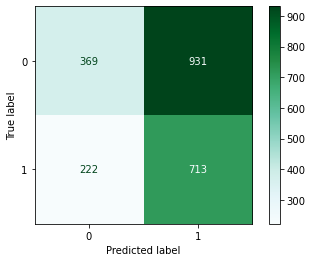

QDA Model on Full Data Complete


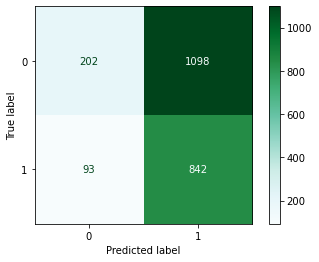

QDA Model on Data Subset Complete


In [42]:
qda_accuracy_full = run_QDA_classification(xl_full,yl,graph=True)
print(f'QDA Model on Full Data Complete')
qda_accuracy_part = run_QDA_classification(xl_part,yl,graph=True)
print(f'QDA Model on Data Subset Complete')

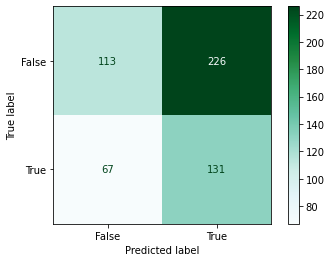

Logistic Model on Full Data Complete


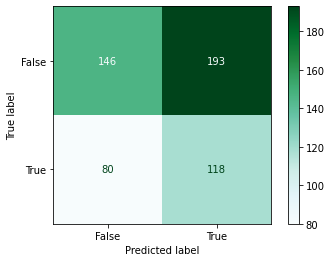

Logistic Model on Data Subset Complete


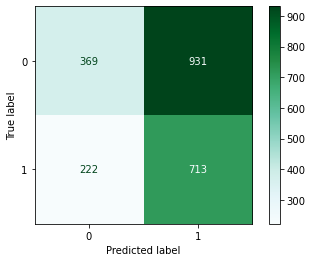

QDA Model on Full Data Complete


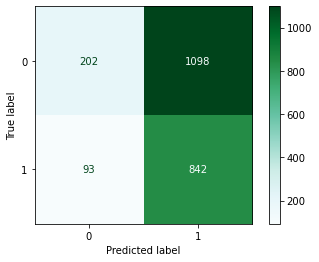

QDA Model on Data Subset Complete


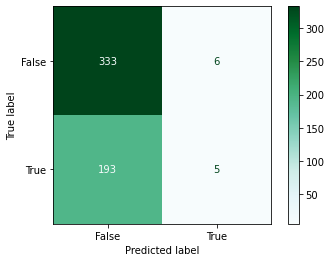

Ridge Class Model on Full Data Complete


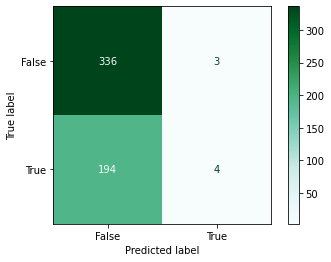

Ridge Class Model on Data Subset Complete


In [38]:
log_accuracy_full = run_logistic(xl_full,yl,graph=True)
print(f'Logistic Model on Full Data Complete')
log_accuracy_part = run_logistic(xl_part,yl,graph=True)
print(f'Logistic Model on Data Subset Complete')
qda_accuracy_full = run_QDA_classification(xl_full,yl,graph=True)
print(f'QDA Model on Full Data Complete')
qda_accuracy_part = run_QDA_classification(xl_part,yl,graph=True)
print(f'QDA Model on Data Subset Complete')
ridge_accuracy_full = run_ridge_classification(xl_full,yl,a_start = .1,a_stop = 20,a_step=.1,graph=True)
print(f'Ridge Class Model on Full Data Complete')
ridge_accuracy_part = run_ridge_classification(xl_part,yl,a_start = .1,a_stop = 20,a_step=.1,graph=True)
print(f'Ridge Class Model on Data Subset Complete')


best_depth = 4 | best_tree_val = 500


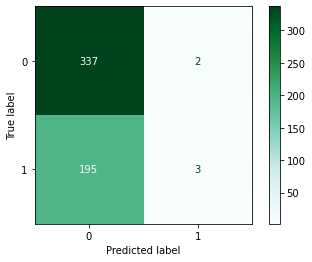

Random Forest Model on Data Subset Complete
best_depth = 1 | best_tree_val = 500


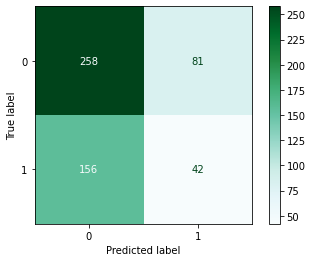

Boosted Trees Model on Full Dataset Complete
best_depth = 1 | best_tree_val = 500


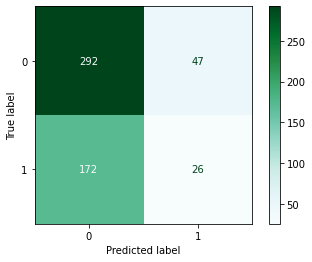

Boosted Trees Model on Data Subset Complete


In [39]:
#decision tree classfiications
# fitting trees of depth 1 to 9 and of size 500,1500,2500
sm_tree_depths = range(1,10)
sm_tree_nbr = range(500,2500,1000)
rf_accuracy_part = run_cross_validation_on_classification_RF(xl_part,yl,sm_tree_depths,sm_tree_nbr,graph=True)
print(f'Random Forest Model on Data Subset Complete')
boost_accuracy_full = run_cross_validation_on_classification_Boost(xl_full,yl,sm_tree_depths,sm_tree_nbr,graph=True)
print(f'Boosted Trees Model on Full Dataset Complete')
boost_accuracy_part = run_cross_validation_on_classification_Boost(xl_part,yl,sm_tree_depths,sm_tree_nbr,graph=True)
print(f'Boosted Trees Model on Data Subset Complete')

In [44]:
#create a data frame of the results for analysis
result_aa_list  = [['Logistic Run 1','Full',log_accuracy_full]
                  ,['Logistic Run 2','Partial',log_accuracy_part]
                  #,['QDA Run 1','Full',qda_accuracy_full]
                  #,['QDA Run 2','Partial',qda_accuracy_part]
                  #,['Elastic Net Run 1','Full',enet_rmse,enet_r2]
                  #,['Elastic Net Run 2','Subset',enet_part_rmse,enet_part_r2]
                  ,['Ridge Run 1','Full',ridge_accuracy_full]
                  ,['Ridge Run 2','Partial',ridge_accuracy_part]
                  ,['Random Forest Run 1','Partial',rf_accuracy_part]
                  ,['Boosted Trees Run 1','Full',boost_accuracy_full]
                  ,['Boosted Trees Run 2','Partial',boost_accuracy_part]]
results_above_average = pd.DataFrame(result_aa_list,columns=['Model_Name','Data_Used','Accuracy'])
results_above_average.sort_values(['Accuracy'],ascending=[False])

,Model_Name,Data_Used,Accuracy
3,Ridge Run 2,Partial,0.633147
4,Random Forest Run 1,Partial,0.633147
2,Ridge Run 1,Full,0.629423
6,Boosted Trees Run 2,Partial,0.592179
5,Boosted Trees Run 1,Full,0.558659
1,Logistic Run 2,Partial,0.491620
0,Logistic Run 1,Full,0.454376
